# Genre Fix

This dataset has too many genres, they are too granular. The aim of this notebook:
1. Split problematic genres, those with "joint" genres, e.g. "Science and Drama".
2. Normalize genres to common names.
3. Combine genres until there are 10 main ones.

## Import data

In [8]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *

In [9]:
embeddings, movie_ids  = load_movie_embeddings(os.path.join(base_path, "data", 'data_final'))

In [10]:
embeddings.shape

(87718, 1024)

In [11]:
movie_ids.shape

(87718,)

In [12]:
movie_df = load_movie_data(os.path.join(base_path, "data", "data_final"))

In [13]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141119 entries, 0 to 141118
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   movie_id                       141119 non-null  object
 1   country                        138264 non-null  object
 2   imdb_id                        137125 non-null  object
 3   duration                       79499 non-null   object
 4   duration_all                   79499 non-null   object
 5   actors_id                      108527 non-null  object
 6   actors                         108527 non-null  object
 7   directors_id                   128578 non-null  object
 8   directors                      128578 non-null  object
 9   genre_id                       118524 non-null  object
 10  genre                          118524 non-null  object
 11  release_date                   141119 non-null  object
 12  wikidata_class                 141119 non-nu

In [14]:
movie_df[movie_df.year==1950].shape

(1222, 31)

## Genre exploration

In [15]:
all_genres = movie_df[movie_df.genre.notna()].genre.unique()

In [16]:
all_genres

array(['drama film, film based on literature',
       'drama film, war film, biographical film, historical film',
       'drama film, romance film', ..., 'erotic thriller film',
       'association football film, sports documentary',
       'found footage, psychological horror film'],
      shape=(12232,), dtype=object)

In [17]:
# Sample randomly and see examples of genres
import random

print(random.choice(all_genres))
print(random.choice(all_genres))
print(random.choice(all_genres))
print(random.choice(all_genres))
print(random.choice(all_genres))

musical film, comedy drama, family film, coming-of-age film, romantic comedy film
fantasy film, comedy drama, film based on literature
horror film, biopunk, zombie film, science fiction horror film
drama film, horror film, crime film, mystery film, thriller film, film based on a novel
action film, adventure film, treasure hunt film


In [18]:
random.choice(all_genres[np.array(["and" in i for i in all_genres])])

'science fiction anime and manga, science fiction video game'

It seems like the common delimeters are commas and "and". Splitting by these should give us all possible genres, however there weirder ones like "film from a novel". 

In [19]:
# First split by "," and "and"
import re

def split_all_genres(genre: str):
    split_genres = genre.split(",")
    split_genres = list(set([i.lower().replace("film", "").strip() for i in split_genres]))
    return "|".join(split_genres)

new_genres = []
for row in all_genres:
    split_genres = row.split(",")
    split_genres = [i.lower().replace("film", "").strip() for i in split_genres]
    new_genres.extend(split_genres)

In [20]:
non_null_genres = movie_df[movie_df.genre.notna()].reset_index(drop=True)

In [21]:
non_null_genres["genre_cleaned"] = non_null_genres["genre"].apply(split_all_genres)

In [22]:
from collections import Counter

In [23]:
genre_counter = Counter(new_genres)

In [24]:
len(genre_counter)

819

In [25]:
genre_counter.most_common(10)

[('drama', 4199),
 ('action', 2401),
 ('comedy', 2174),
 ('thriller', 1743),
 ('horror', 1693),
 ('science fiction', 1667),
 ('fantasy', 1570),
 ('adventure', 1552),
 ('crime', 1380),
 ('romance', 1077)]

Check how many movies will be lost if we drop movies out of top 10

In [26]:
def genre_in_top_10(genre_cleaned: str, top_10: list[str]) -> bool:
    for genre in top_10:
        if genre in genre_cleaned:
            return True
        
    return False

In [27]:
top_10_genres = [i[0] for i in genre_counter.most_common(20)]

In [28]:
non_null_genres["genre_in_top_10"] = non_null_genres["genre_cleaned"].apply(lambda x: genre_in_top_10(x, top_10_genres))

In [29]:
non_null_genres[~non_null_genres.genre_in_top_10].shape

(17477, 33)

In [30]:
non_null_genres.shape

(118524, 33)

Use sentence transformers to embed genres and cluster them.

In [31]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

/home/nab/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# model = SentenceTransformer('all-MiniLM-L6-v2')


In [33]:
genre_embeddings = model.encode(new_genres)

In [34]:
genre_embeddings.shape

(46052, 384)

In [35]:
# Clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=123)
labels = kmeans.fit_predict(genre_embeddings)

In [36]:
genre_clusters = pd.DataFrame({"genre": new_genres, "cluster": labels})

In [37]:
genre_clusters[genre_clusters.cluster==9].genre.unique()

array(['romance', 'lgbt-related', 'thriller', 'fantasy', 'erotic',
       'suspense', 'psychological thriller', 'action thriller',
       'erotic thriller', 'political thriller', 'romantic thriller',
       'supernatural', 'noir fiction', 'neo-noir', 'bisexual',
       'lesbian-related', 'lgbt-related television series',
       'horror western', 'lesbian pornographic', 'romantic fantasy',
       'thriller anime', 'erotic horror', 'monster erotica',
       'dark fantasy', 'romance television series',
       'thriller television series', 'fantasy television series',
       'gothic romance', 'techno-thriller', 'legal thriller',
       'romance anime', 'lovecraftian horror', 'love triangle romance',
       'romance adventure game', 'noir novel', 'erotic drama',
       'romantic fiction', 'medical thriller', 'neo-psychedelia',
       'fantasy video game', 'gay pornographic', 'portal fantasy',
       'erotica', 'horror literature', 'urban fantasy', 'high fantasy',
       'romantic horror', '

10 Main clusters:
* cluster 0: Others
* cluster 1: Comedy
* cluster 2: Romance
* cluster 3: Drama
* cluster 4: Fantasy
* cluster 5: Action
* cluster 6: Science Fiction
* cluster 7: Family
* cluster 8: Mystery
* cluster 9: Thriller

In [38]:
cluster_label_mapping = {
    0: "others",
    1: "comedy",
    2: "romance",
    3: "drama",
    4: "fantasy",
    5: "action",
    6: "scifi",
    7: "family",
    8: "mystery",
    9: "thriller"
}

In [39]:
genre_clusters["new_label"] = genre_clusters["cluster"].apply(lambda x: cluster_label_mapping[x])

In [40]:
movie_df.genre

0                      drama film, film based on literature
1         drama film, war film, biographical film, histo...
2                                  drama film, romance film
3                             documentary film, silent film
4               drama film, war film, film based on a novel
                                ...                        
141114                                                  NaN
141115                                        thriller film
141116                                                  NaN
141117                    comedy film, science fiction film
141118                                                  NaN
Name: genre, Length: 141119, dtype: object

In [41]:
for genre in cluster_label_mapping.values():
    print(f"Genre - {genre.upper()}")
    original_genres = genre_clusters[genre_clusters.new_label == genre].genre.unique()
    for i, original_g in enumerate(original_genres):
        print(f"    - {original_g}")

Genre - OTHERS
    - war
    - silent
    - mystery
    - buddy
    - heist
    - satanic
    - horror
    - fairy tale
    - mountain
    - adventure
    - monster
    - short
    - race
    - sport
    - disaster
    - noir
    - tragicomedy
    - epic
    - vampire
    - experimental
    - time-travel
    - children's
    - zombie
    - slasher
    - ghost
    - family
    - mythology
    - slice of life
    - teen
    - post-apocalyptic
    - christmas
    - pirate
    - treasure hunt
    - bushranging
    - road movie
    - folklore
    - novella
    - jewish
    - newsreel
    - superhero
    - educational
    - black
    - female buddy
    - social
    - werewolf
    - coming-of-age
    - social problem
    - sponsored
    - survival
    - gambling
    - corporate
    - rubble
    - pornographic
    - caper story
    - alien invasion
    - submarine
    - natural horror
    - tragedy
    - ethnofiction
    - gothic
    - supernatural horror
    - surf
    - psychological horror


In [42]:
# Generate json file for genre to cluster mapping
map_df = genre_clusters.drop_duplicates("genre").drop(columns=["cluster"])
mapping_dict = {}
for i, row in map_df.iterrows():
    mapping_dict[row["genre"]] = row["new_label"]

In [43]:
len(mapping_dict)

819

In [44]:
import json

In [45]:
with open("../genre_fix_mapping.json", "w") as f:
    f.write(json.dumps(mapping_dict))

In [46]:
with open("../genre_fix_mapping.json", "r") as f:
    test = json.loads(f.read())

In [47]:
test["musical"]

'romance'

Seems to work fine (some pretty weird labelling e.g. War movies in Family genre.).

Suggestion was to try genre clustering using more context, such as scraping the wikipedia entries for each genre.

## Genre clustering using wiki entries

In [129]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

notebook_dir = Path().resolve()
base_path = os.path.abspath(notebook_dir.parent.parent)
sys.path.append(base_path)
from src.data_utils import *
from src.api.wikipedia_handler import get_page_from_url
from src.data_cleaning import clean_dataset

In [ ]:
movie_df = load_movie_data(os.path.join(base_path, "data", "data_final"))
movie_df = clean_dataset(movie_df)

Original dataset size: 141119
After filtering movies without plot: 99336


RuntimeError: asyncio.run() cannot be called from a running event loop

In [53]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141119 entries, 0 to 141118
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   movie_id                       141119 non-null  object
 1   country                        138264 non-null  object
 2   imdb_id                        137125 non-null  object
 3   duration                       79499 non-null   object
 4   duration_all                   79499 non-null   object
 5   actors_id                      108527 non-null  object
 6   actors                         108527 non-null  object
 7   directors_id                   128578 non-null  object
 8   directors                      128578 non-null  object
 9   genre_id                       118524 non-null  object
 10  genre                          118524 non-null  object
 11  release_date                   141119 non-null  object
 12  wikidata_class                 141119 non-nu

In [58]:
rand_row = movie_df.sample(1).iloc[0]
print(rand_row.genre_id)
print(rand_row.genre)

Q200092,Q1054574
horror film, romance film


In [59]:
movie_df["genre_wiki_id_len"] = movie_df["genre_id"].apply(lambda x: len(x.split(",")) if isinstance(x, str) else 0)

In [60]:
movie_df.genre_wiki_id_len.max()

np.int64(25)

In [61]:
import requests
import wikipediaapi

def get_wikipedia_title_from_wikiid(genre_id: str) -> str | None:
    try:
        media_wiki_url = "https://www.wikidata.org/w/api.php?action=wbgetentities&format=json&languages=en&sitefilter=enwiki&ids={wikiid}"
        user_agent = 'GroupDataLiteracy/1.0 (movie data pipeline)'

        mediawiki_response = requests.get(media_wiki_url.format(wikiid=genre_id), headers={"User-Agent": user_agent})

        json_response = mediawiki_response.json()

        genre_wikipedia_title = json_response["entities"][list(json_response["entities"].keys())[0]]["sitelinks"]["enwiki"]["title"]

        return genre_wikipedia_title
    except Exception as e:
        print(f"Unable to get wikipedia Title of genre_id: {genre_id}, error: {e}")
        return None

user_agent = 'GroupDataLiteracy/1.0 (movie data pipeline)'
wiki_wiki = wikipediaapi.Wikipedia(
        user_agent=user_agent,
        language='en'
    )

def get_wikipedia_description_from_title(genre_title: str, wiki_wiki) -> str:
    try:
        genre_page = get_page_from_url(wiki_wiki, f"https://en.wikipedia.org/wiki/{genre_title.lower().replace(' ', '_')}")
        if genre_page is None or not genre_page.exists():
            return ""
        return genre_page.summary
    except Exception as e:
        print(f"Error fetching genre {genre}: {e}")
        return ""

In [62]:
raw_genres = movie_df[movie_df.genre.notna()].genre.unique()

In [63]:
# Split genres by comma and strip whitespace
split_genres = []
for genre in raw_genres:
    parts = genre.split(",")
    parts = [part.strip() for part in parts]
    split_genres.extend(parts)

In [64]:
unique_genres = list(set(split_genres))

In [65]:
len(unique_genres)

865

In [66]:
from tqdm import tqdm

In [67]:
# Get all wikipedia descriptions of unique genres
user_agent = 'GroupDataLiteracy/1.0 (movie data pipeline)'
wiki_wiki = wikipediaapi.Wikipedia(
        user_agent=user_agent,
        language='en'
    )

genre_descriptions = {}
for genre in tqdm(unique_genres, total=len(unique_genres), desc="Fetching genre descriptions"):
    description = get_wikipedia_description_from_title(genre, wiki_wiki)
    genre_descriptions[genre] = description

Fetching genre descriptions:   0%|          | 4/865 [00:01<04:01,  3.56it/s]

Error fetching genre romance television program: Wikipedia page not found: romance television program
Error fetching genre romantic comedy anime and manga: Wikipedia page not found: romantic comedy anime and manga


Fetching genre descriptions:   1%|          | 7/865 [00:02<03:47,  3.77it/s]

Error fetching genre intersex film: Wikipedia page not found: intersex film


Fetching genre descriptions:   1%|▏         | 12/865 [00:04<04:48,  2.96it/s]

Error fetching genre speculative fiction comedy: Wikipedia page not found: speculative fiction comedy


Fetching genre descriptions:   2%|▏         | 14/865 [00:04<04:15,  3.34it/s]

Error fetching genre adventure anime and manga: Wikipedia page not found: adventure anime and manga


Fetching genre descriptions:   3%|▎         | 23/865 [00:09<04:54,  2.86it/s]

Error fetching genre bushranging film: Wikipedia page not found: bushranging film


Fetching genre descriptions:   3%|▎         | 29/865 [00:11<04:30,  3.09it/s]

Error fetching genre comedy of error: Wikipedia page not found: comedy of error


Fetching genre descriptions:   4%|▍         | 37/865 [00:14<04:00,  3.44it/s]

Error fetching genre film based on book: Wikipedia page not found: film based on book


Fetching genre descriptions:   5%|▍         | 41/865 [00:15<03:14,  4.25it/s]

Error fetching genre treasure hunt film: Wikipedia page not found: treasure hunt film
Error fetching genre romantic television drama: Wikipedia page not found: romantic television drama


Fetching genre descriptions:   6%|▌         | 51/865 [00:20<06:03,  2.24it/s]

Error fetching genre time-travel film: Wikipedia page not found: time-travel film
Error fetching genre huis-clos film: Wikipedia page not found: huis-clos film


Fetching genre descriptions:   7%|▋         | 58/865 [00:23<04:41,  2.87it/s]

Error fetching genre pritcha: Wikipedia page not found: pritcha


Fetching genre descriptions:   9%|▊         | 75/865 [00:31<06:20,  2.08it/s]

Error fetching genre spoken drama: Wikipedia page not found: spoken drama


Fetching genre descriptions:   9%|▉         | 77/865 [00:32<04:33,  2.88it/s]

Error fetching genre vampire film in Italy: Wikipedia page not found: vampire film in italy


Fetching genre descriptions:   9%|▉         | 79/865 [00:32<03:58,  3.30it/s]

Error fetching genre film based on literature: Wikipedia page not found: film based on literature


Fetching genre descriptions:  10%|▉         | 86/865 [00:35<04:14,  3.06it/s]

Error fetching genre post-apocalyptic video game: Wikipedia page not found: post-apocalyptic video game


Fetching genre descriptions:  10%|█         | 89/865 [00:36<03:40,  3.51it/s]

Error fetching genre abstract animation film: Wikipedia page not found: abstract animation film


Fetching genre descriptions:  11%|█         | 93/865 [00:37<03:55,  3.27it/s]

Error fetching genre social drama: Wikipedia page not found: social drama


Fetching genre descriptions:  11%|█         | 96/865 [00:38<03:08,  4.09it/s]

Error fetching genre diary film: Wikipedia page not found: diary film
Error fetching genre ballet film: Wikipedia page not found: ballet film


Fetching genre descriptions:  13%|█▎        | 111/865 [00:46<04:19,  2.90it/s]

Error fetching genre black-and-white cinema: Wikipedia page not found: black-and-white cinema
Error fetching genre religious film: Wikipedia page not found: religious film


Fetching genre descriptions:  13%|█▎        | 113/865 [00:47<04:13,  2.97it/s]

Error fetching genre body horror television program: Wikipedia page not found: body horror television program


Fetching genre descriptions:  14%|█▍        | 122/865 [00:50<03:41,  3.35it/s]

Error fetching genre science fiction animation: Wikipedia page not found: science fiction animation


Fetching genre descriptions:  14%|█▍        | 124/865 [00:50<03:11,  3.88it/s]

Error fetching genre CMC Pictures: Wikipedia page not found: cmc pictures


Fetching genre descriptions:  15%|█▍        | 127/865 [00:51<03:10,  3.88it/s]

Error fetching genre science fiction anime and manga: Wikipedia page not found: science fiction anime and manga
Error fetching genre novella film: Wikipedia page not found: novella film


Fetching genre descriptions:  15%|█▍        | 128/865 [00:52<02:50,  4.32it/s]

Error fetching genre culture clash comedy: Wikipedia page not found: culture clash comedy


Fetching genre descriptions:  16%|█▌        | 138/865 [00:56<03:42,  3.27it/s]

Error fetching genre supernatural anime and manga: Wikipedia page not found: supernatural anime and manga


Fetching genre descriptions:  16%|█▋        | 141/865 [00:56<03:28,  3.48it/s]

Error fetching genre film installation: Wikipedia page not found: film installation


Fetching genre descriptions:  17%|█▋        | 143/865 [00:57<03:27,  3.47it/s]

Error fetching genre Sámi film: Wikipedia page not found: sámi film


Fetching genre descriptions:  17%|█▋        | 147/865 [00:58<03:25,  3.50it/s]

Error fetching genre Schlagerfilm: Wikipedia page not found: schlagerfilm


Fetching genre descriptions:  18%|█▊        | 158/865 [01:03<03:45,  3.14it/s]

Error fetching genre alternate history film: Wikipedia page not found: alternate history film


Fetching genre descriptions:  18%|█▊        | 160/865 [01:04<03:13,  3.64it/s]

Error fetching genre school anime and manga: Wikipedia page not found: school anime and manga


Fetching genre descriptions:  20%|█▉        | 172/865 [01:08<03:47,  3.04it/s]

Error fetching genre Euro War: Wikipedia page not found: euro war


Fetching genre descriptions:  20%|██        | 176/865 [01:10<03:09,  3.64it/s]

Error fetching genre romance anime and manga: Wikipedia page not found: romance anime and manga
Error fetching genre magic realist film: Wikipedia page not found: magic realist film


Fetching genre descriptions:  20%|██        | 177/865 [01:10<02:45,  4.17it/s]

Error fetching genre detective television series: Wikipedia page not found: detective television series


Fetching genre descriptions:  21%|██        | 181/865 [01:11<03:11,  3.58it/s]

Error fetching genre music documentary film: Wikipedia page not found: music documentary film


Fetching genre descriptions:  21%|██▏       | 185/865 [01:12<03:03,  3.70it/s]

Error fetching genre ice hockey film: Wikipedia page not found: ice hockey film
Error fetching genre space adventure film: Wikipedia page not found: space adventure film


Fetching genre descriptions:  22%|██▏       | 187/865 [01:13<02:28,  4.58it/s]

Error fetching genre comical satyre: Wikipedia page not found: comical satyre
Error fetching genre holiday-themed film: Wikipedia page not found: holiday-themed film


Fetching genre descriptions:  22%|██▏       | 191/865 [01:14<02:42,  4.14it/s]

Error fetching genre historical documentary film: Wikipedia page not found: historical documentary film
Error fetching genre fantasy video game: Wikipedia page not found: fantasy video game


Fetching genre descriptions:  23%|██▎       | 195/865 [01:15<03:40,  3.04it/s]

Error fetching genre Lustspiel: Wikipedia page not found: lustspiel


Fetching genre descriptions:  24%|██▍       | 206/865 [01:19<03:14,  3.39it/s]

Error fetching genre cinematic fairy tale: Wikipedia page not found: cinematic fairy tale


Fetching genre descriptions:  25%|██▍       | 212/865 [01:21<03:15,  3.34it/s]

Error fetching genre student film: Wikipedia page not found: student film


Fetching genre descriptions:  25%|██▍       | 215/865 [01:22<03:05,  3.51it/s]

Error fetching genre biographical sports film: Wikipedia page not found: biographical sports film


Fetching genre descriptions:  25%|██▌       | 220/865 [01:24<02:53,  3.72it/s]

Error fetching genre women's association football film: Wikipedia page not found: women's association football film


Fetching genre descriptions:  26%|██▌       | 226/865 [01:25<02:59,  3.57it/s]

Error fetching genre historical television series: Wikipedia page not found: historical television series
Error fetching genre moral drama: Wikipedia page not found: moral drama


Fetching genre descriptions:  27%|██▋       | 231/865 [01:28<04:12,  2.51it/s]

Error fetching genre Landismo: Wikipedia page not found: landismo


Fetching genre descriptions:  28%|██▊       | 238/865 [01:30<02:37,  3.99it/s]

Error fetching genre Jewish film: Wikipedia page not found: jewish film
Error fetching genre coming-of-age drama: Wikipedia page not found: coming-of-age drama


Fetching genre descriptions:  28%|██▊       | 239/865 [01:30<02:22,  4.40it/s]

Error fetching genre comedy television program: Wikipedia page not found: comedy television program


Fetching genre descriptions:  29%|██▊       | 248/865 [01:34<04:31,  2.27it/s]

Error fetching genre animated film with LGBT character(s): Wikipedia page not found: animated film with lgbt character(s)


Fetching genre descriptions:  29%|██▉       | 250/865 [01:34<03:27,  2.97it/s]

Error fetching genre Holocaust in the movies: Wikipedia page not found: holocaust in the movies


Fetching genre descriptions:  29%|██▉       | 252/865 [01:35<03:05,  3.30it/s]

Error fetching genre prequel film: Wikipedia page not found: prequel film


Fetching genre descriptions:  30%|███       | 261/865 [01:39<03:43,  2.70it/s]

Error fetching genre love triangle romance: Wikipedia page not found: love triangle romance


Fetching genre descriptions:  31%|███       | 269/865 [01:43<04:09,  2.39it/s]

Error fetching genre fantasy television program: Wikipedia page not found: fantasy television program


Fetching genre descriptions:  32%|███▏      | 273/865 [01:44<03:00,  3.28it/s]

Error fetching genre sports documentary: Wikipedia page not found: sports documentary


Fetching genre descriptions:  32%|███▏      | 278/865 [01:45<02:29,  3.92it/s]

Error fetching genre gambling film: Wikipedia page not found: gambling film
Error fetching genre American football film: Wikipedia page not found: american football film


Fetching genre descriptions:  32%|███▏      | 280/865 [01:46<02:38,  3.69it/s]

Error fetching genre moral film: Wikipedia page not found: moral film


Fetching genre descriptions:  33%|███▎      | 286/865 [01:48<03:12,  3.01it/s]

Error fetching genre music-themed film: Wikipedia page not found: music-themed film


Fetching genre descriptions:  33%|███▎      | 289/865 [01:49<02:44,  3.50it/s]

Error fetching genre thriller anime: Wikipedia page not found: thriller anime


Fetching genre descriptions:  34%|███▍      | 293/865 [01:50<02:18,  4.13it/s]

Error fetching genre space drama: Wikipedia page not found: space drama
Error fetching genre fantasy anime and manga: Wikipedia page not found: fantasy anime and manga


Fetching genre descriptions:  34%|███▍      | 294/865 [01:50<02:04,  4.58it/s]

Error fetching genre triathlon films: Wikipedia page not found: triathlon films


Fetching genre descriptions:  35%|███▍      | 299/865 [01:52<02:55,  3.23it/s]

Error fetching genre zombie television program: Wikipedia page not found: zombie television program


Fetching genre descriptions:  35%|███▍      | 302/865 [01:53<02:45,  3.41it/s]

Error fetching genre satirical film or television program: Wikipedia page not found: satirical film or television program


Fetching genre descriptions:  35%|███▌      | 304/865 [01:54<02:26,  3.84it/s]

Error fetching genre teen drama television: Wikipedia page not found: teen drama television


Fetching genre descriptions:  35%|███▌      | 307/865 [01:55<02:28,  3.76it/s]

Error fetching genre television series based on a novel: Wikipedia page not found: television series based on a novel


Fetching genre descriptions:  36%|███▋      | 314/865 [01:57<02:59,  3.08it/s]

Error fetching genre family television series: Wikipedia page not found: family television series


Fetching genre descriptions:  37%|███▋      | 320/865 [01:59<02:56,  3.09it/s]

Error fetching genre animals documentary: Wikipedia page not found: animals documentary


Fetching genre descriptions:  37%|███▋      | 324/865 [02:01<02:38,  3.41it/s]

Error fetching genre circus film: Wikipedia page not found: circus film


Fetching genre descriptions:  38%|███▊      | 328/865 [02:02<02:53,  3.09it/s]

Error fetching genre gothic horror film: Wikipedia page not found: gothic horror film


Fetching genre descriptions:  38%|███▊      | 333/865 [02:04<02:54,  3.04it/s]

Error fetching genre proletarian film: Wikipedia page not found: proletarian film


Fetching genre descriptions:  39%|███▊      | 335/865 [02:05<02:29,  3.55it/s]

Error fetching genre adventure science fiction: Wikipedia page not found: adventure science fiction


Fetching genre descriptions:  39%|███▉      | 339/865 [02:06<02:17,  3.83it/s]

Error fetching genre bullfighting film: Wikipedia page not found: bullfighting film


Fetching genre descriptions:  39%|███▉      | 341/865 [02:06<02:21,  3.70it/s]

Error fetching genre flashback film: Wikipedia page not found: flashback film


Fetching genre descriptions:  40%|████      | 347/865 [02:09<02:47,  3.09it/s]

Error fetching genre gag anime: Wikipedia page not found: gag anime


Fetching genre descriptions:  41%|████      | 354/865 [02:11<02:44,  3.11it/s]

Error fetching genre comedy porn film: Wikipedia page not found: comedy porn film


Fetching genre descriptions:  42%|████▏     | 365/865 [02:15<02:36,  3.19it/s]

Error fetching genre traditionally animated film: Wikipedia page not found: traditionally animated film


Fetching genre descriptions:  43%|████▎     | 369/865 [02:16<02:14,  3.69it/s]

Error fetching genre historical anime and manga: Wikipedia page not found: historical anime and manga
Error fetching genre Q12962776: Wikipedia page not found: q12962776


Fetching genre descriptions:  43%|████▎     | 370/865 [02:16<01:56,  4.26it/s]

Error fetching genre production cinema: Wikipedia page not found: production cinema


Fetching genre descriptions:  43%|████▎     | 373/865 [02:17<02:04,  3.95it/s]

Error fetching genre fantasy television series: Wikipedia page not found: fantasy television series


Fetching genre descriptions:  45%|████▍     | 388/865 [02:24<02:07,  3.74it/s]

Error fetching genre transgender film: Wikipedia page not found: transgender film
Error fetching genre historical prose literature: Wikipedia page not found: historical prose literature


Fetching genre descriptions:  46%|████▌     | 396/865 [02:27<02:43,  2.87it/s]

Error fetching genre aqua-musical: Wikipedia page not found: aqua-musical


Fetching genre descriptions:  46%|████▋     | 402/865 [02:29<02:31,  3.05it/s]

Error fetching genre classical antiquity film: Wikipedia page not found: classical antiquity film


Fetching genre descriptions:  47%|████▋     | 409/865 [02:31<02:10,  3.48it/s]

Error fetching genre contemporary Western film: Wikipedia page not found: contemporary western film


Fetching genre descriptions:  48%|████▊     | 411/865 [02:32<01:58,  3.83it/s]

Error fetching genre animal horror film: Wikipedia page not found: animal horror film


Fetching genre descriptions:  48%|████▊     | 415/865 [02:33<02:12,  3.39it/s]

Error fetching genre horror fantasy film: Wikipedia page not found: horror fantasy film


Fetching genre descriptions:  48%|████▊     | 419/865 [02:34<02:09,  3.44it/s]

Error fetching genre youth series: Wikipedia page not found: youth series


Fetching genre descriptions:  51%|█████     | 443/865 [02:45<02:15,  3.12it/s]

Error fetching genre lesbian-related film: Wikipedia page not found: lesbian-related film


Fetching genre descriptions:  52%|█████▏    | 447/865 [02:47<02:11,  3.18it/s]

Error fetching genre romantic drama fiction: Wikipedia page not found: romantic drama fiction


Fetching genre descriptions:  52%|█████▏    | 450/865 [02:48<02:21,  2.93it/s]

Error fetching genre contemporary R&B: Wikipedia page not found: contemporary r&b


Fetching genre descriptions:  52%|█████▏    | 453/865 [02:49<02:09,  3.18it/s]

Error fetching genre vampire anime and manga: Wikipedia page not found: vampire anime and manga


Fetching genre descriptions:  54%|█████▍    | 466/865 [02:54<02:02,  3.25it/s]

Error fetching genre war comedy film: Wikipedia page not found: war comedy film


Fetching genre descriptions:  54%|█████▍    | 468/865 [02:54<01:50,  3.59it/s]

Error fetching genre political magazine show: Wikipedia page not found: political magazine show


Fetching genre descriptions:  55%|█████▌    | 477/865 [02:57<01:53,  3.43it/s]

Error fetching genre Staliniana: Wikipedia page not found: staliniana


Fetching genre descriptions:  56%|█████▌    | 482/865 [02:59<01:45,  3.65it/s]

Error fetching genre adventure television series: Wikipedia page not found: adventure television series
Error fetching genre crime documentary: Wikipedia page not found: crime documentary


Fetching genre descriptions:  57%|█████▋    | 489/865 [03:01<01:51,  3.38it/s]

Error fetching genre mystery anime and manga: Wikipedia page not found: mystery anime and manga


Fetching genre descriptions:  57%|█████▋    | 493/865 [03:03<01:40,  3.71it/s]

Error fetching genre romance adventure game: Wikipedia page not found: romance adventure game
Error fetching genre MILF pornography: Wikipedia page not found: milf pornography


Fetching genre descriptions:  57%|█████▋    | 496/865 [03:03<01:36,  3.83it/s]

Error fetching genre Australian Western: Wikipedia page not found: australian western


Fetching genre descriptions:  58%|█████▊    | 500/865 [03:05<01:58,  3.08it/s]

Error fetching genre Golden Age of Porn: Wikipedia page not found: golden age of porn


Fetching genre descriptions:  58%|█████▊    | 504/865 [03:06<01:25,  4.23it/s]

Error fetching genre Sherlock Holmes television program: Wikipedia page not found: sherlock holmes television program
Error fetching genre Toei Company: Wikipedia page not found: toei company


Fetching genre descriptions:  59%|█████▊    | 508/865 [03:07<01:26,  4.12it/s]

Error fetching genre werewolf television program: Wikipedia page not found: werewolf television program


Fetching genre descriptions:  60%|██████    | 519/865 [03:11<01:43,  3.33it/s]

Error fetching genre behind-the-scenes film: Wikipedia page not found: behind-the-scenes film
Error fetching genre athletics film: Wikipedia page not found: athletics film


Fetching genre descriptions:  61%|██████    | 527/865 [03:14<01:35,  3.53it/s]

Error fetching genre film based on a novel: Wikipedia page not found: film based on a novel
Error fetching genre film performance: Wikipedia page not found: film performance


Fetching genre descriptions:  61%|██████    | 529/865 [03:15<02:07,  2.63it/s]

Error fetching genre biographical television program: Wikipedia page not found: biographical television program


Fetching genre descriptions:  62%|██████▏   | 533/865 [03:16<01:38,  3.37it/s]

Error fetching genre fantastique film: Wikipedia page not found: fantastique film


Fetching genre descriptions:  62%|██████▏   | 536/865 [03:17<01:30,  3.63it/s]

Error fetching genre coming-of-age anime and manga: Wikipedia page not found: coming-of-age anime and manga


Fetching genre descriptions:  63%|██████▎   | 544/865 [03:21<03:15,  1.64it/s]

Error fetching genre popular science film: Wikipedia page not found: popular science film


Fetching genre descriptions:  63%|██████▎   | 547/865 [03:22<02:07,  2.50it/s]

Error fetching genre fantasy epic film: Wikipedia page not found: fantasy epic film


Fetching genre descriptions:  64%|██████▎   | 550/865 [03:24<01:56,  2.70it/s]

Error fetching genre Manchurian Western: Wikipedia page not found: manchurian western


Fetching genre descriptions:  64%|██████▍   | 553/865 [03:24<01:28,  3.51it/s]

Error fetching genre Greatest Movie Hits: Wikipedia page not found: greatest movie hits


Fetching genre descriptions:  65%|██████▍   | 559/865 [03:27<02:04,  2.46it/s]

Error fetching genre blaxploitation horror film: Wikipedia page not found: blaxploitation horror film


Fetching genre descriptions:  65%|██████▍   | 561/865 [03:27<01:35,  3.19it/s]

Error fetching genre backwoods film: Wikipedia page not found: backwoods film


Fetching genre descriptions:  66%|██████▌   | 569/865 [03:31<01:38,  3.01it/s]

Error fetching genre http://www.wikidata.org/.well-known/genid/dbd688a8636928a57f9cbec7cbe874f8: Wikipedia page not found: http://www.wikidata.org/.well-known/genid/dbd688a8636928a57f9cbec7cbe874f8
Error fetching genre social comedy film: Wikipedia page not found: social comedy film


Fetching genre descriptions:  66%|██████▌   | 570/865 [03:32<01:23,  3.55it/s]

Error fetching genre extraterrestrial film: Wikipedia page not found: extraterrestrial film


Fetching genre descriptions:  66%|██████▋   | 574/865 [03:33<01:22,  3.52it/s]

Error fetching genre slice of life anime and manga: Wikipedia page not found: slice of life anime and manga


Fetching genre descriptions:  68%|██████▊   | 586/865 [03:38<01:35,  2.91it/s]

Error fetching genre science fiction television program: Wikipedia page not found: science fiction television program


Fetching genre descriptions:  68%|██████▊   | 589/865 [03:39<01:26,  3.18it/s]

Error fetching genre stop-motion animated film: Wikipedia page not found: stop-motion animated film


Fetching genre descriptions:  71%|███████   | 610/865 [03:47<01:33,  2.72it/s]

Error fetching genre post-apocalyptic anime: Wikipedia page not found: post-apocalyptic anime


Fetching genre descriptions:  71%|███████▏  | 617/865 [03:49<01:31,  2.70it/s]

Error fetching genre comedia ranchera: Wikipedia page not found: comedia ranchera


Fetching genre descriptions:  72%|███████▏  | 623/865 [03:52<01:25,  2.83it/s]

Error fetching genre marionette film: Wikipedia page not found: marionette film


Fetching genre descriptions:  72%|███████▏  | 627/865 [03:53<00:59,  4.03it/s]

Error fetching genre Horror based on children's characters: Wikipedia page not found: horror based on children's characters
Error fetching genre Bible film: Wikipedia page not found: bible film


Fetching genre descriptions:  73%|███████▎  | 628/865 [03:53<00:53,  4.41it/s]

Error fetching genre LGBT-related television series: Wikipedia page not found: lgbt-related television series


Fetching genre descriptions:  73%|███████▎  | 633/865 [03:55<01:05,  3.53it/s]

Error fetching genre vampire television program: Wikipedia page not found: vampire television program


Fetching genre descriptions:  75%|███████▍  | 645/865 [04:00<01:33,  2.36it/s]

Error fetching genre autobiographical film: Wikipedia page not found: autobiographical film


Fetching genre descriptions:  76%|███████▌  | 656/865 [04:04<01:02,  3.33it/s]

Error fetching genre horror television series: Wikipedia page not found: horror television series


Fetching genre descriptions:  76%|███████▌  | 659/865 [04:05<00:59,  3.44it/s]

Error fetching genre action anime and manga: Wikipedia page not found: action anime and manga


Fetching genre descriptions:  77%|███████▋  | 667/865 [04:08<01:05,  3.02it/s]

Error fetching genre LGBT-related film: Wikipedia page not found: lgbt-related film


Fetching genre descriptions:  77%|███████▋  | 669/865 [04:08<00:56,  3.45it/s]

Error fetching genre romantic horror film: Wikipedia page not found: romantic horror film


Fetching genre descriptions:  78%|███████▊  | 676/865 [04:11<01:02,  3.03it/s]

Error fetching genre spokon: Wikipedia page not found: spokon


Fetching genre descriptions:  79%|███████▊  | 680/865 [04:13<01:06,  2.80it/s]

Error fetching genre anti-religious propaganda: Wikipedia page not found: anti-religious propaganda
Error fetching genre espionage television series: Wikipedia page not found: espionage television series


Fetching genre descriptions:  79%|███████▉  | 682/865 [04:13<00:59,  3.07it/s]

Error fetching genre Neue Deutsche Härte: Wikipedia page not found: neue deutsche härte


Fetching genre descriptions:  79%|███████▉  | 685/865 [04:15<00:58,  3.05it/s]

Error fetching genre war television series: Wikipedia page not found: war television series


Fetching genre descriptions:  80%|████████  | 693/865 [04:18<00:55,  3.08it/s]

Error fetching genre high school film: Wikipedia page not found: high school film


Fetching genre descriptions:  80%|████████  | 696/865 [04:19<00:54,  3.08it/s]

Error fetching genre grotesque film: Wikipedia page not found: grotesque film


Fetching genre descriptions:  81%|████████  | 699/865 [04:19<00:42,  3.91it/s]

Error fetching genre fustanella film: Wikipedia page not found: fustanella film
Error fetching genre Halloween film: Wikipedia page not found: halloween film


Fetching genre descriptions:  81%|████████▏ | 703/865 [04:21<00:42,  3.79it/s]

Error fetching genre crime television series: Wikipedia page not found: crime television series


Fetching genre descriptions:  82%|████████▏ | 705/865 [04:23<01:30,  1.77it/s]

Error fetching genre action television series: Wikipedia page not found: action television series


Fetching genre descriptions:  82%|████████▏ | 709/865 [04:24<00:52,  2.95it/s]

Error fetching genre horror anime and manga: Wikipedia page not found: horror anime and manga


Fetching genre descriptions:  82%|████████▏ | 712/865 [04:25<00:46,  3.27it/s]

Error fetching genre erotic drama film: Wikipedia page not found: erotic drama film


Fetching genre descriptions:  83%|████████▎ | 714/865 [04:25<00:36,  4.16it/s]

Error fetching genre eskrima film: Wikipedia page not found: eskrima film
Error fetching genre knight film: Wikipedia page not found: knight film


Fetching genre descriptions:  83%|████████▎ | 718/865 [04:26<00:41,  3.52it/s]

Error fetching genre cosmic horror film: Wikipedia page not found: cosmic horror film


Fetching genre descriptions:  83%|████████▎ | 722/865 [04:28<01:01,  2.33it/s]

Error fetching genre chase film: Wikipedia page not found: chase film


Fetching genre descriptions:  85%|████████▍ | 734/865 [04:33<00:38,  3.37it/s]

Error fetching genre coming-of-age fiction: Wikipedia page not found: coming-of-age fiction


Fetching genre descriptions:  85%|████████▌ | 736/865 [04:33<00:33,  3.88it/s]

Error fetching genre Q20107852: Wikipedia page not found: q20107852


Fetching genre descriptions:  85%|████████▌ | 739/865 [04:34<00:31,  3.94it/s]

Error fetching genre school anime: Wikipedia page not found: school anime


Fetching genre descriptions:  86%|████████▌ | 744/865 [04:35<00:33,  3.61it/s]

Error fetching genre procedural television drama: Wikipedia page not found: procedural television drama


Fetching genre descriptions:  87%|████████▋ | 750/865 [04:38<00:36,  3.18it/s]

Error fetching genre post-apocalyptic anime and manga: Wikipedia page not found: post-apocalyptic anime and manga


Fetching genre descriptions:  87%|████████▋ | 752/865 [04:38<00:31,  3.64it/s]

Error fetching genre romance television series: Wikipedia page not found: romance television series


Fetching genre descriptions:  87%|████████▋ | 756/865 [04:39<00:29,  3.65it/s]

Error fetching genre supernatural anime: Wikipedia page not found: supernatural anime
Error fetching genre action anime: Wikipedia page not found: action anime


Fetching genre descriptions:  88%|████████▊ | 761/865 [04:41<00:34,  3.00it/s]

Error fetching genre xiaoshuo: Wikipedia page not found: xiaoshuo


Fetching genre descriptions:  88%|████████▊ | 765/865 [04:43<00:40,  2.50it/s]

Error fetching genre drama fiction: Wikipedia page not found: drama fiction


Fetching genre descriptions:  89%|████████▉ | 768/865 [04:44<00:28,  3.40it/s]

Error fetching genre animated television film: Wikipedia page not found: animated television film
Error fetching genre rural drama: Wikipedia page not found: rural drama


Fetching genre descriptions:  89%|████████▉ | 769/865 [04:44<00:24,  3.90it/s]

Error fetching genre mature film: Wikipedia page not found: mature film


Fetching genre descriptions:  89%|████████▉ | 771/865 [04:45<00:26,  3.60it/s]

Error fetching genre spy comedy film: Wikipedia page not found: spy comedy film


Fetching genre descriptions:  90%|████████▉ | 775/865 [04:46<00:25,  3.48it/s]

Error fetching genre biographical work: Wikipedia page not found: biographical work


Fetching genre descriptions:  90%|█████████ | 779/865 [04:48<00:25,  3.43it/s]

Error fetching genre Ozploitation film: Wikipedia page not found: ozploitation film


Fetching genre descriptions:  91%|█████████ | 783/865 [04:50<00:30,  2.68it/s]

Error fetching genre folk horror film: Wikipedia page not found: folk horror film


Fetching genre descriptions:  91%|█████████▏| 791/865 [04:53<00:21,  3.37it/s]

Error fetching genre comedy drama anime and manga: Wikipedia page not found: comedy drama anime and manga


Fetching genre descriptions:  92%|█████████▏| 794/865 [04:54<00:20,  3.40it/s]

Error fetching genre gay-related film: Wikipedia page not found: gay-related film


Fetching genre descriptions:  92%|█████████▏| 796/865 [04:54<00:17,  3.84it/s]

Error fetching genre children and youth program: Wikipedia page not found: children and youth program


Fetching genre descriptions:  95%|█████████▌| 824/865 [05:09<00:13,  3.08it/s]

Error fetching genre association football video game: Wikipedia page not found: association football video game


Fetching genre descriptions:  95%|█████████▌| 826/865 [05:09<00:10,  3.73it/s]

Error fetching genre teen horror film: Wikipedia page not found: teen horror film


Fetching genre descriptions:  96%|█████████▌| 829/865 [05:10<00:09,  3.86it/s]

Error fetching genre sword-and-sandal film: Wikipedia page not found: sword-and-sandal film


Fetching genre descriptions:  96%|█████████▌| 831/865 [05:11<00:09,  3.56it/s]

Error fetching genre drama television program: Wikipedia page not found: drama television program


Fetching genre descriptions:  96%|█████████▋| 833/865 [05:11<00:08,  3.65it/s]

Error fetching genre drama anime and manga: Wikipedia page not found: drama anime and manga


Fetching genre descriptions:  97%|█████████▋| 836/865 [05:12<00:07,  3.66it/s]

Error fetching genre Romanian historical film: Wikipedia page not found: romanian historical film


Fetching genre descriptions:  97%|█████████▋| 840/865 [05:13<00:06,  4.14it/s]

Error fetching genre steampunk film: Wikipedia page not found: steampunk film
Error fetching genre bisexual film: Wikipedia page not found: bisexual film


Fetching genre descriptions:  98%|█████████▊| 845/865 [05:15<00:06,  3.16it/s]

Error fetching genre comedy anime and manga: Wikipedia page not found: comedy anime and manga


Fetching genre descriptions:  98%|█████████▊| 850/865 [05:17<00:04,  3.22it/s]

Error fetching genre military comedy film: Wikipedia page not found: military comedy film


Fetching genre descriptions:  99%|█████████▉| 855/865 [05:18<00:02,  3.72it/s]

Error fetching genre musical drama: Wikipedia page not found: musical drama
Error fetching genre thriller television series: Wikipedia page not found: thriller television series


Fetching genre descriptions:  99%|█████████▉| 857/865 [05:19<00:02,  3.80it/s]

Error fetching genre association football film: Wikipedia page not found: association football film


Fetching genre descriptions: 100%|█████████▉| 862/865 [05:21<00:00,  3.42it/s]

Error fetching genre BDSM-themed film: Wikipedia page not found: bdsm-themed film


Fetching genre descriptions: 100%|██████████| 865/865 [05:22<00:00,  2.68it/s]


In [68]:
genre_description_df = pd.DataFrame.from_dict(genre_descriptions, orient='index', columns=['description']).reset_index().rename(columns={'index': 'genre'})

In [95]:
genre_description_df.to_csv("genre_description_df.csv", index=False)

In [ ]:
genre_description_df = pd.read_csv("genre_description_df.csv")

In [70]:
genre_description_df[genre_description_df.description.str.len() == 0]

,genre,description
2,romance television program,
3,romantic comedy anime and manga,
6,intersex film,
11,speculative fiction comedy,
13,adventure anime and manga,
...,...,...
849,military comedy film,
853,musical drama,
854,thriller television series,
856,association football film,


In [71]:
# Create binary column to indicate if description exists
genre_description_df["has_description"] = genre_description_df["description"].apply(lambda x: 1 if x.strip() != "" else 0)

In [72]:
genre_description_df.has_description.sum()

np.int64(667)

In [73]:
# Fill missing description with the genre itself, so that everyone can get clustered
genre_description_df.loc[genre_description_df.description.str.len() == 0, "description"] = genre_description_df.loc[genre_description_df.description.str.len() == 0, "genre"]

In [122]:
genre_description_df.iloc[25].description

'Opera is a form of Western theatre in which music is a fundamental component and dramatic roles are taken by singers. Such a "work" (the literal translation of the Italian word "opera") is typically a collaboration between a composer and a librettist and incorporates a number of the performing arts, such as acting, scenery, costume, and sometimes dance or ballet. The performance is typically given in an opera house, accompanied by an orchestra or smaller musical ensemble, which since the early 19th century has been led by a conductor. Although musical theatre is closely related to opera, the two are considered to be distinct from one another.\nOpera is a key part of Western classical music, and Italian tradition in particular. Originally understood as an entirely sung piece, in contrast to a play with songs, opera has come to include numerous genres, including some that include spoken dialogue such as Singspiel and Opéra comique. In traditional number opera, singers employ two styles 

In [74]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [104]:
# model = SentenceTransformer('all-MiniLM-L6-v2')
# use a bigger model 500m params
model = SentenceTransformer('Qwen/Qwen3-Embedding-0.6B')

In [105]:
genre_embeddings = model.encode(genre_description_df.description.tolist())

In [106]:
genre_embeddings.shape

(865, 1024)

In [107]:
# Use a smarter clustering method: HDBSCAN (which does not require the number of clusters)
import hdbscan

# Fit HDBSCAN clustering on the embeddings with cosine distance
# HDBSCAN wants metric="cosine" but some installations (as in your error) only support "euclidean", "manhattan", "l2", etc.
# However, per HDBSCAN documentation, "cosine" should work **if** you have scipy >=1.2 and up-to-date scikit-learn.
# The internal BallTree in scikit-learn only supports a few metrics; annoyingly, it does NOT support "cosine" (despite docs).
# The solution is to use 'euclidean' and L2-normalize your genre_embeddings before clustering (cosine-distance between L2-normalized vectors is equivalent to euclidean distance).
import numpy as np
genre_embeddings_norm = genre_embeddings / np.linalg.norm(genre_embeddings, axis=1, keepdims=True)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=20, metric='euclidean')
hdb_labels = clusterer.fit_predict(genre_embeddings_norm)

# Inspect how many clusters HDBSCAN found (excluding noise points, which are labelled -1)
n_hdb_clusters = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
print(f"HDBSCAN found {n_hdb_clusters} clusters.")

/home/nab/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/nab/anaconda3/envs/dataLiteracy/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 3 clusters.


In [110]:
# Calculate cluster distortions
distortions = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(genre_embeddings)
    distortions.append(kmeans.inertia_)

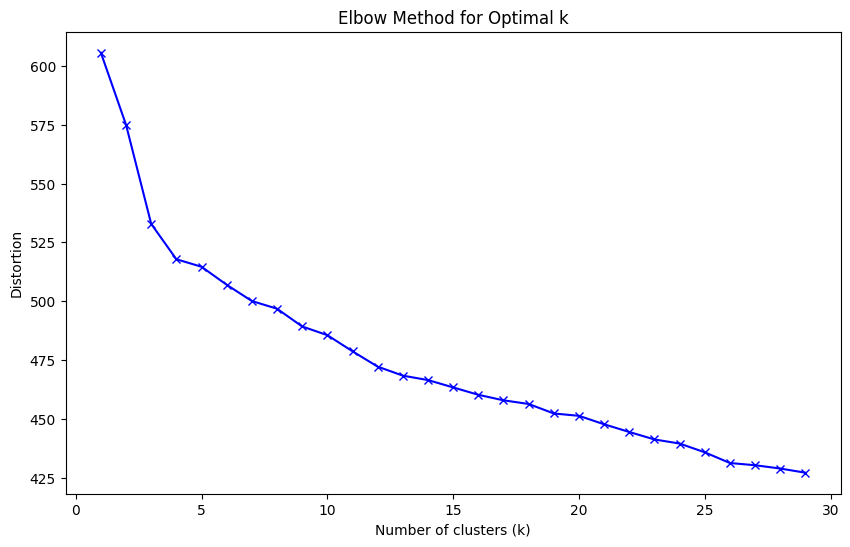

In [111]:
# with the distortions, plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()

In [112]:
# Clustering (choose n = 10, elbow graph does not say much)
n_clusters = 25
kmeans = KMeans(n_clusters=n_clusters, random_state=123)
labels = kmeans.fit_predict(genre_embeddings)

In [113]:
genre_description_df["cluster"] = labels

In [114]:
genre_description_df

,genre,description,has_description,cluster
0,easy listening,Easy listening (including mood music) is a pop...,1,7
1,experimental film,Experimental film or avant-garde cinema is a m...,1,12
2,romance television program,romance television program,0,21
3,romantic comedy anime and manga,romantic comedy anime and manga,0,11
4,nunsploitation,Nunsploitation is a subgenre of exploitation f...,1,3
...,...,...,...,...
860,yuri,Yuri may refer to:,1,3
861,BDSM-themed film,BDSM-themed film,0,15
862,adventure fiction,Adventure fiction is a type of fiction that us...,1,16
863,rape and revenge film,"Rape and revenge, or rape-revenge, is a horror...",1,10


In [119]:
genre_description_df[genre_description_df.cluster==2].genre.unique()

array(['comedy horror', 'science fiction comedy', 'comedy of intrigue',
       'mime', 'science fiction comics', 'comedy of remarriage', 'parody',
       'comical satyre', 'farce', 'comedy hip-hop', 'comedy thriller',
       'cartoon', 'screwball comedy film', 'humor', 'satyr play',
       'slapstick film', 'black comedy', 'comedy horror film',
       'comedy film', 'fantasy comedy film', 'burlesque',
       'surreal humour', 'anti-humor', 'tragicomedy',
       "commedia all'italiana", 'comic book', 'comedy music', 'slapstick',
       'comics', 'adult comics', 'novelty music',
       "commedia sexy all'italiana", 'fantasy comedy',
       'black comedy film', 'sex comedy', 'zombie comedy',
       'polemical lampoon', 'religious satire', 'comedy of manners',
       'stand-up comedy', 'comedy', 'parody film', 'vaudeville',
       'political satire', 'physical comedy', 'satire'], dtype=object)

In [ ]:
genre_mapping = {
    0: "meta/emo/punk music",
    1: "anime",
    2: "romance",
    3: "horror",
    4: "comedy",
    5: "",
    6: "",
    7: "music",
    8: "science fiction",
    9: "metal"
}